![my image caption](1.jpg)

# Description of the problem

The company found out that the previous segmentation of the consumer market, grouped by geography, is not suitable for improving their marketing service. It does not display the actual picture, since there may be 1 doctor with more than 100 purchases in the region, or 7 doctors with 4 purchases. Therefore, the region is not a good predictor of the number of purchases that a doctor will make or his support needs. The company turned to us for help to build a new segmentation of doctors based on the company's data in order to improve marketing, customer service and product planning.

All the technical side will be described consistently in the course of the work. Now let's talk about the result and what characteristics distinguish the new segments.

# The result of the work
In the course of the work, we will confirm the assumption that the region is not suitable for predicting the number of purchases, several features will also be revealed:	
 - eneral practitioners have practically no complaints. Complaints appear in the category of doctors of the "specialist" type, and with the growth of their internal rating, the number of complaints also increases, more than 80% of all complaints come from "higher" ranks (Ambassador, Titanium, Platinum Plus, Platinum).
 - doctors of the rank of "Ambassador" account for more than a third of these complaints, about half of all purchases, despite the fact that there are slightly more than a quarter of such doctors in the total number.

An assumption was made about a new classification of doctors according to their internal ranking system, which will be one of the possible options for a new market segmentation.

Developing this assumption, we combined several data frames into one and added a new categorical column "number of purchases", which divided our data into 3 values ('Small', 'Medium' and 'Large') depending on their number of purchases during the year.

In the resulting data, we conducted clustering with 3 main classes of doctors. According to the data, it is well read that 3 classes characterize our assumption of a new segmentation. Having grouped all doctors in this way, we have created two classification models.
The first predicts which group a particular doctor will fall into, without seeing data about his purchases, relying mainly on the "Incident rate", "R rate","Satisfaction" and "Experience" of the doctor.
The second model tries to predict what level (in the company's internal ranking system) a doctor can get this. The model also does not see the number of purchases he has made, but is based on almost the same functions as the first model.

Based on all of the above and based on the research conducted in the work, the marketing department can try to build a new strategy in the relationship of working with clients and it would be wonderful to check or refute this theory together. What is great about data analysis in this situation is that it allows you to react as quickly as possible to any changes or test new theories.

# Beginning of research work
## 💾 The data

The company stores the information you need in the following four tables. Some of the fields are anonymized to comply with privacy regulations.

#### Doctors contains information on doctors. Each row represents one doctor.
- "DoctorID" - is a unique identifier for each doctor.
- "Region" - the current geographical region of the doctor.
- "Category" - the type of doctor, either 'Specialist' or 'General Practitioner.'
- "Rank" - is an internal ranking system. It is an ordered variable: The highest level is Ambassadors, followed by Titanium Plus, Titanium, Platinum Plus, Platinum, Gold Plus, Gold, Silver Plus, and the lowest level is Silver.
- "Incidence rate"  and "R rate" - relate to the amount of re-work each doctor generates.
- "Satisfaction" - measures doctors' satisfaction with the company.
- "Experience" - relates to the doctor's experience with the company.
- "Purchases" - purchases over the last year.

#### Orders contains details on orders. Each row represents one order; a doctor can place multiple orders.
- "DoctorID" - doctor id (matches the other tables).
- "OrderID" - order identifier.
- "OrderNum" - order number.
- "Conditions A through J" - map the different settings of the devices in each order. Each order goes to an individual patient.

#### Complaints collects information on doctor complaints.
- "DoctorID" - doctor id (matches the other tables).
- "Complaint Type" - the company's classification of the complaints.
- "Qty" - number of complaints per complaint type per doctor.

#### Instructions has information on whether the doctor includes special instructions on their orders.
- "DoctorID" - doctor id (matches the other tables).
- "Instructions" - 'Yes' when the doctor includes special instructions, 'No' when they do not.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

In [5]:
doctors = pd.read_csv('data/doctors.csv')
doctors.columns = doctors.columns.str.replace(' ', '_')

doctors.head(3)

,DoctorID,Region,Category,Rank,Incidence_rate,R_rate,Satisfaction,Experience,Purchases
0,AHDCBA,4 15,Specialist,Ambassador,49.0,0.90,53.85,1.2,49.0
1,ABHAHF,1 8 T4,General Practitioner,Ambassador,37.0,0.00,100.00,0.0,38.0
2,FDHFJ,1 9 T4,Specialist,Ambassador,33.0,1.53,--,0.0,34.0


In [6]:
orders = pd.read_csv('data/orders.csv')
orders.columns = orders.columns.str.replace(' ', '_')

orders.head(3)

,DoctorID,OrderID,OrderNum,Condition_A,Condition_B,Condition_C,Condition_D,Condition_F,Condition_G,Condition_H,Condition_I,Condition_J
0,ABJEAI,DGEJFDC,AIBEHCJ,False,False,False,False,False,True,True,False,Before
1,HBIEA,DGAJDAH,AIJIHGB,False,True,NaN,False,False,True,False,True,Before
2,GGCCD,DGBBDCB,AFEIHFB,False,False,False,False,False,False,False,False,NaN


In [7]:
complaints = pd.read_csv('data/complaints.csv')
complaints.columns = complaints.columns.str.replace(' ', '_')

complaints.head(3)

,DoctorID,Complaint_Type,Qty
0,EHAHI,Correct,10
1,EHDGF,Correct,2
2,EHDGF,Unknown,3


In [8]:
instructions = pd.read_csv('data/instructions.csv')
instructions.head(3)

,DoctorID,Instructions
0,ADIFBD,Yes
1,ABHBED,No
2,FJFEG,Yes


## The beginning of the analysis
Let's start with the standard actions when analyzing a dataframe. Let's look at the data types, whether there are missing values and duplicates.

In [9]:
doctors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DoctorID        437 non-null    object 
 1   Region          437 non-null    object 
 2   Category        437 non-null    object 
 3   Rank            435 non-null    object 
 4   Incidence_rate  437 non-null    float64
 5   R_rate          437 non-null    float64
 6   Satisfaction    437 non-null    object 
 7   Experience      437 non-null    float64
 8   Purchases       437 non-null    float64
dtypes: float64(4), object(5)
memory usage: 30.9+ KB


In [10]:
doctors[doctors.duplicated()]

,DoctorID,Region,Category,Rank,Incidence_rate,R_rate,Satisfaction,Experience,Purchases


In [11]:
doctors[doctors.Rank.isna()]

,DoctorID,Region,Category,Rank,Incidence_rate,R_rate,Satisfaction,Experience,Purchases
110,BBAHCA,5 18,Specialist,NaN,6.0,3.14,--,1.43,7.0
217,AHABIB,5 18,General Practitioner,NaN,4.0,1.00,83.33,2.00,4.0


As you can see, there is a value in the "Satisfaction" column that cannot be interpreted in the future, replace it with 0. Next, let's look at our data and see how many unique values there are.

In [12]:
doctors.Satisfaction = doctors.Satisfaction.replace('--','0').astype('float')

In [13]:
variables = pd.DataFrame(columns=['Variable','Number of unique values','Values'])

for i, var in enumerate(doctors.columns):
    variables.loc[i] = [var, doctors[var].nunique(), doctors[var].unique().tolist()]
variables.set_index('Variable', inplace=True)    
variables

,Number of unique values,Values
Variable,,
DoctorID,437,"[AHDCBA, ABHAHF, FDHFJ, BJJHCA, FJBEA, BCJCED,..."
Region,46,"[4 15, 1 8 T4, 1 9 T4, 1 10 T3, 1 14 T4, 1 10,..."
Category,2,"[Specialist, General Practitioner]"
Rank,9,"[Ambassador, Platinum Plus, Titanium, Silver P..."
Incidence_rate,63,"[49.0, 37.0, 33.0, 28.0, 23.0, 19.0, 18.0, 15...."
R_rate,137,"[0.9, 0.0, 1.53, 2.03, 0.96, 1.2, 1.68, 1.19, ..."
Satisfaction,98,"[53.85, 100.0, 0.0, 76.79, -50.0, 14.29, 66.67..."
Experience,106,"[1.2, 0.0, 0.48, 0.75, 0.1, 0.26, 0.38, 0.25, ..."
Purchases,45,"[49.0, 38.0, 34.0, 29.0, 24.0, 20.0, 19.0, 16...."


## How many doctors...
Let's answer the first question: How many doctors are there in each region?

In [14]:
count_doct_per_region = doctors.groupby('Region').count()\
							   .rename(columns={"DoctorID": "count"})['count']\
							   .sort_values(ascending =False)\
							   .reset_index()
count_doct_per_region.head(10)

,Region,count
0,1 13,34
1,1 9,32
2,1 14,32
3,1 19,31
4,1 11,23
5,1 12,23
6,1 8,21
7,1 10,15
8,1 14 T3,15
9,2 7 19,14


We received a table with the number of doctors in each region. 
#### The largest region with the code "1 13" has 34 doctors.

Now let's see how much the average number of purchases in each region is.

In [15]:
mean_purch_per_region = doctors.groupby('Region')\
							   .agg({'Purchases' :['mean','count','sum']})\
							   .sort_values(by =[('Purchases','mean')],ascending =False)\
 							   .reset_index().round(1)
mean_purch_per_region.head(10)

Region Purchases             
                mean count    sum
0  1 19 20     129.0     1  129.0
1  1 13 T4      30.0     1   30.0
2  1 19 T4      25.3     9  228.0
3   1 9 T4      23.4     7  164.0
4     4 15      23.3     3   70.0
5  1 12 T4      22.5     2   45.0
6  1 14 T4      19.5     4   78.0
7   1 8 T4      18.5     6  111.0
8     1 10      15.0    15  225.0
9     1 12      14.9    23  343.0

As we saw, the grouping, as it was at the firm initially, is not the most successful, because only two regions out of the top 10 in terms of the number of doctors entered the top 10 in terms of the average number of purchases, taking 9th and 10th place there. 
#### The first places in this list are occupied by regions with only 1 doctor each.

Having answered the first of the questions posed in the competition, then we will try to find the relationship between purchases and complaints.

The dataframe itself with the number of complaints won 't give us much information . In it, we can see the distribution of complaints by their type and the number of doctors in them. Let's combine this dataframe with data about purchases from the dataframe about doctors and try to find the relationship between purchases and complaints.

It can be seen that most of the complaints, 451 complaints, are displayed as "correct" and the number of doctors is 205. Also
, the type of complaint classified as "unknown" is quite important.

In [16]:
complaints.groupby('Complaint_Type').agg({'Qty' :['count','sum']})

Qty     
               count  sum
Complaint_Type           
Correct          205  451
Incorrect        118  173
R&R                1    1
Specific           6    8
Unknown          103  145

After combining the data, we received 125 lines about purchases and complaints from doctors. Of these, 74 are unique values.

In [17]:
doct_compl = pd.merge(doctors,complaints, how ='inner',on ='DoctorID')

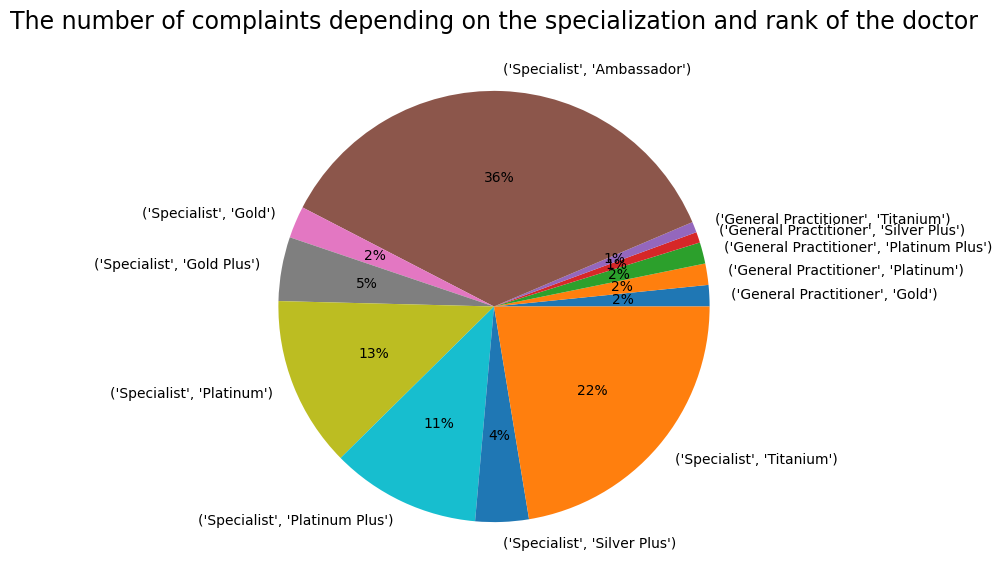

In [18]:
categ_rank = doct_compl.groupby(['Category','Rank']).agg({'Qty' :['count','sum'], 'Purchases' :['sum']})
pie, ax = plt.subplots(figsize=[12,7])
plt.pie(x=categ_rank[('Qty', 'count')], autopct="%.f%%",labels =categ_rank.index);
plt.title("The number of complaints depending on the specialization and rank of the doctor", fontsize=17);



The diagram shows that general practitioners have practically no complaints. Complaints appear in the category of doctors of the "specialist" type, and with the growth of their internal ranking, the number of complaints also increases. It is clearly visible that more than 80% of complaints come from "higher" ranks (Ambassador,Titanium, Platinum Plus, Platinum). Let's move on to further consideration of this subgroup.

In [19]:
purch_compl = doct_compl.query('Category == "Specialist"')\
						.groupby(['Complaint_Type','Rank'])\
						.agg({'Qty' :['count','sum'], 'Purchases' :['sum']})\
						.sort_values(by = ('Qty', 'count'), ascending = False)
purch_compl[purch_compl[('Qty', 'count')] >2]

Qty     Purchases
                             count sum       sum
Complaint_Type Rank                             
Correct        Ambassador       23  51     704.0
Incorrect      Ambassador       13  24     448.0
Correct        Titanium         10  36     108.0
Unknown        Ambassador        9  10     267.0
Incorrect      Titanium          8  17      91.0
Unknown        Titanium          8  13     101.0
Correct        Platinum          7  24      46.0
               Platinum Plus     7  24      53.0
Unknown        Platinum          5  12      32.0
Incorrect      Platinum          4   9      27.0
Unknown        Platinum Plus     4   4      33.0
               Silver Plus       3   3      26.0
Incorrect      Platinum Plus     3   7      32.0

## Relationship between purchases and complaints
From the available dataframe about doctors, it is difficult to find an explanation for why there are so many dissatisfied among highly qualified doctors. Neither the breakdown into regions, nor the level of "satisfaction" and "experience" provide an explanation for this effect.We found out that the number of purchases is closely related to the internal ranking of the doctor.

According to calculations, it turns out that doctors of the highest rank of "Ambassador" account for 37% of complaints (based on the combined dataframe) , 49% of all purchases, despite the fact that such doctors are slightly more than a quarter of the total number. So it is obvious that our assumptions about the new classification of doctors according to their internal ranking system is one of the possible options for a new market segmentation. Let's move on to this question in more detail and try to answer it.

## The most popular orders
Having studied the dataframe "Orders", we can say that orders prevail in which all conditions from "A" to "I" are False, such orders are 101 of the total number, for the next number where "Condition H" is True, the rest are False of such 23 orders. 14 orders where "G" and "H" are true, and 10 where only "Condition A" is true.

Let's see which doctors make the most popular orders.

In [20]:
merge = pd.merge(doct_compl,orders, how ='inner',on ='DoctorID')

merge['Condition_C'] = merge['Condition_C'].fillna(merge['Condition_C'].mode()[0])
merge['Condition_F'] = merge['Condition_F'].fillna(merge['Condition_F'].mode()[0])
merge['Condition_G'] = merge['Condition_G'].fillna(merge['Condition_G'].mode()[0])
merge['Condition_J'] = merge['Condition_J'].fillna(merge['Condition_J'].mode()[0])


In [21]:
variables = pd.DataFrame(columns=['Variable','Number of unique values','Values'])

for i, var in enumerate(merge.columns):
    variables.loc[i] = [var, merge[var].nunique(), merge[var].unique().tolist()]
variables.set_index('Variable', inplace=True)    
variables

,Number of unique values,Values
Variable,,
DoctorID,74,"[FCBDC, IFDIB, FDHGC, AHIEIG, AEFEAG, AHDDAI, ..."
Region,27,"[2 7 19, 1 19 T3, 1 14, 1 12, 1 10, 1 13, 1 19..."
Category,2,"[Specialist, General Practitioner]"
Rank,7,"[Silver Plus, Titanium, Ambassador, Platinum P..."
Incidence_rate,29,"[14.0, 13.0, 12.0, 11.33, 10.0, 9.0, 8.0, 7.0,..."
R_rate,50,"[0.07, 1.29, 0.85, 1.0, 1.1, 1.45, 1.11, 0.9, ..."
Satisfaction,34,"[0.0, 37.5, 46.67, -31.58, -100.0, 31.58, 100...."
Experience,44,"[0.07, 0.14, 0.62, 0.3, 0.0, 0.18, 0.11, 0.7, ..."
Purchases,31,"[14.0, 13.0, 37.0, 10.0, 11.0, 9.0, 18.0, 8.0,..."


In [22]:
most_pop_order = merge.query('Condition_A ==False and Condition_B ==False and Condition_C ==False and Condition_D ==False and Condition_F ==False and Condition_G ==False and Condition_H ==False and Condition_I ==False')

In [23]:
most_pop_order.head(3)

,DoctorID,Region,Category,Rank,Incidence_rate,R_rate,Satisfaction,Experience,Purchases,Complaint_Type,...,OrderNum,Condition_A,Condition_B,Condition_C,Condition_D,Condition_F,Condition_G,Condition_H,Condition_I,Condition_J
0,FCBDC,2 7 19,Specialist,Silver Plus,14.00,0.07,0.0,0.07,14.0,Unknown,...,AADBICE,False,False,False,False,False,False,False,False,Before
1,IFDIB,1 19 T3,Specialist,Titanium,13.00,1.29,37.5,0.14,14.0,Correct,...,ACBECBD,False,False,False,False,False,False,False,False,Before
18,AHIEIG,1 12,Specialist,Ambassador,11.33,1.00,0.0,0.30,37.0,Correct,...,AGEBABE,False,False,False,False,False,False,False,False,Before


In [24]:
most_pop_order.groupby('Rank').agg({'Purchases' :['count','sum']})\
						.sort_values(by = ('Purchases', 'count'), ascending = False)

Purchases        
                  count     sum
Rank                           
Ambassador           81  2410.0
Platinum             39   254.0
Titanium             19   186.0
Gold Plus            14    58.0
Platinum Plus        10    95.0
Gold                  7    22.0
Silver Plus           3    26.0

And again, we received that doctors with the rank of "Ambassador" issued several times more of the most popular orders than all the others.

## Let's start clustering our sample.

We will first create a new categorical column in the date frame, which will summarize the number of purchases by three criteria:

1 "Small" - less than 15 purchases

2 "Medium" from 15 to 30 purchases

3 "Large " more than 30 purchases

Next, we will use the KMeans algorithm and cluster our data. We have determined that our optimal data is divided into 3 clusters.

In [25]:
def to_category(item):
    if item['Purchases'] <15:
        return 'Small'
    elif item['Purchases'] >=15 and item['Purchases'] <30:
    	return 'Medium'
    elif item['Purchases'] >=30:
    	return 'Large'
  

In [26]:
most_pop_order["Number_orders"] = most_pop_order.apply(to_category, axis=1)

samples = most_pop_order[[ 'Incidence_rate', 'R_rate',
       'Satisfaction', 'Experience', 'Purchases', 'Qty',
        'Condition_A', 'Condition_B', 'Condition_C',
       'Condition_D', 'Condition_F', 'Condition_G', 'Condition_H',
       'Condition_I' ]]

In [27]:
model = KMeans(n_clusters = 3,random_state=1)
labels = model.fit_predict(samples)

df = pd.DataFrame({'labels': labels, 'Number of purchases': most_pop_order["Number_orders"]})
ct = pd.crosstab(df['labels'],df['Number of purchases'])

print(ct)


Number of purchases  Large  Medium  Small
labels                                   
0                        0       3     94
1                        4      18     14
2                       36       4      0


The cross-table shows that doctors are really well divided into 3 groups, depending on the purchases they have made.

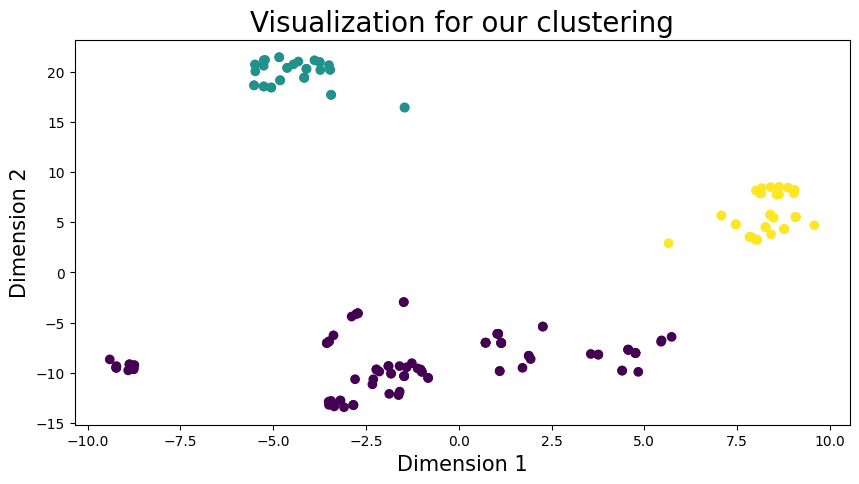

In [28]:
tsne = TSNE(learning_rate=50,random_state=1)
tsne_features = tsne.fit_transform(samples)

xs = tsne_features[:,0]


ys = tsne_features[:,1]

plt.figure(figsize = [10,5])
plt.title("Visualization for our clustering", fontsize = 20)
plt.xlabel("Dimension 1", fontsize = 15)
plt.ylabel("Dimension 2", fontsize = 15)
plt.scatter(xs, ys, c=labels)
plt.show()

The graph also perfectly shows that we have all doctors can be divided into three groups, they certainly have some data outliers from these groups. Attempts to group them again by a different number of purchases, or to increase the number of clusters, did not bring visible results. So it was decided to leave the division into 3 groups and see if the model works well on new data, which contains all types of orders and not just the most popular.

In [29]:
merge["Number_orders"] = merge.apply(to_category, axis=1)
merge[['Rank','Number_orders']] = merge[['Rank','Number_orders']].astype('category')

samples1 = merge[[ 'Incidence_rate', 'R_rate',
       'Satisfaction', 'Experience', 'Purchases', 'Qty',
        'Condition_A', 'Condition_B', 'Condition_C',
       'Condition_D', 'Condition_F', 'Condition_G', 'Condition_H',
       'Condition_I', ]]
labels1 = model.predict(samples1)
df_all = pd.DataFrame({'labels': labels1, 'Number of purchases': merge["Number_orders"]})
ct_all = pd.crosstab(df_all['labels'],df_all['Number of purchases'])

print(ct_all)

Number of purchases  Large  Medium  Small
labels                                   
0                        0      10    253
1                       13      41     21
2                       79       6      0


It can be seen that the combined dataframe is also clearly divided into 3 main clusters.

### A few words about the functions
In the final report, I did not include my calculations about reducing the number of functions used in the model (PCA), but I still need to say a few words. Since the data is small enough, no special computing power is required for the calculation. Therefore, to use all the functions in creating a model, to try to reduce their number, as a result, our analysis will not receive any visible advantages. I want to say that the data from the "Orders" table practically does not affect the decision of the models, in the main function that have an impact is information about the qualifications of the doctor, satisfaction with the company (about which I would also like to say a few words below), Incident rate" and "R rate".

Unfortunately, the data in the "Satisfaction" column remained not fully understood by me, and their meager description contributed to this. Because it is not entirely clear on what scale this value is measured, from 0 to 100, and then negative values can be considered an error, or negative values are an outgrowth of the negative to the company, then what attitude does the doctor express to the company if the value in this column is 0. Of course, the presence of "feedback" from the company would contribute to a better understanding, and in consequence and data analysis.
#### Therefore, this column in the data leaves more questions than answers them.

### Let's move on to building machine learning models.

The first model will predict which group the doctor will fall into, using information about his experience, satisfaction with the company, the number of complaints, data that relate to his repeated work and information about the order itself. We have specifically deleted all the information related to the purchase of orthopedic products by a doctor so that the model could predict the newly joined doctors.

In [30]:
y = merge.loc[:,"Number_orders"]
X =merge.loc[:,['Incidence_rate', 'R_rate','Satisfaction',
        'Experience', 'Qty',
        'Condition_A', 'Condition_B', 'Condition_C',
       'Condition_D', 'Condition_F', 'Condition_G', 'Condition_H',
       'Condition_I', ]]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test , test_size=0.4,
random_state=1)

lr_1 = LogisticRegression(C=17.171,)
svc_1 = SVC(kernel = 'linear' , C = 1,gamma = 1e-05,  )
forest = RandomForestClassifier(n_estimators=50, max_depth=9,min_samples_leaf=1, min_samples_split=2 ,random_state=1)


svc_1.fit(X_train, y_train)
forest.fit(X_train, y_train)
lr_1.fit(X_train,y_train)

svc_pred1 = svc_1.predict(X_test)
forest_pred = forest.predict(X_test)
lr_pred1 = lr_1.predict(X_test)

print("Accuracy of logistic regression classifier: ", accuracy_score(y_test, lr_pred1))
print("Accuracy of the svc model = %f" %accuracy_score(y_test, svc_pred1) )
print("Accuracy of the forest model = %f" %accuracy_score(y_test, forest_pred) )

Accuracy of logistic regression classifier:  0.7368421052631579
Accuracy of the svc model = 0.763158
Accuracy of the forest model = 0.973684


In [32]:
print("f1-score of the svc model on test data = %f" %f1_score(y_test, svc_pred1, average='weighted') )
print("f1-score of the forest model on test data = %f" %f1_score(y_test, forest_pred, average='weighted'))
print("f1-score of the logistic regression on test data = %f" %f1_score(y_test, lr_pred1, average='weighted'))

f1-score of the svc model on test data = 0.737224
f1-score of the forest model on test data = 0.973345
f1-score of the logistic regression on test data = 0.708903


In [33]:
print("f1-score of the svc model on validation data = %f" %f1_score(y_val, svc_1.predict(X_val), average='weighted') )
print("f1-score of the tree model on validation data = %f" %f1_score(y_val, forest.predict(X_val), average='weighted') )
print("f1-score of the  logistic regression on validation data = %f" %f1_score(y_val, lr_1.predict(X_val), average='weighted') )


f1-score of the svc model on validation data = 0.756692
f1-score of the tree model on validation data = 0.936611
f1-score of the  logistic regression on validation data = 0.741025


In [34]:
print("Accuracy of the forest model based on verification data = {0:.2f}".format(accuracy_score(y_val, forest.predict(X_val))))
print("Accuracy of the logistic regression classifier based on verification data = {0:.2f}".format(accuracy_score(y_val, lr_1.predict(X_val))))
print("Accuracy of the svc model based on verification data = {0:.2f}".format(accuracy_score(y_val, svc_1.predict(X_val))))

Accuracy of the forest model based on verification data = 0.94
Accuracy of the logistic regression classifier based on verification data = 0.76
Accuracy of the svc model based on verification data = 0.78


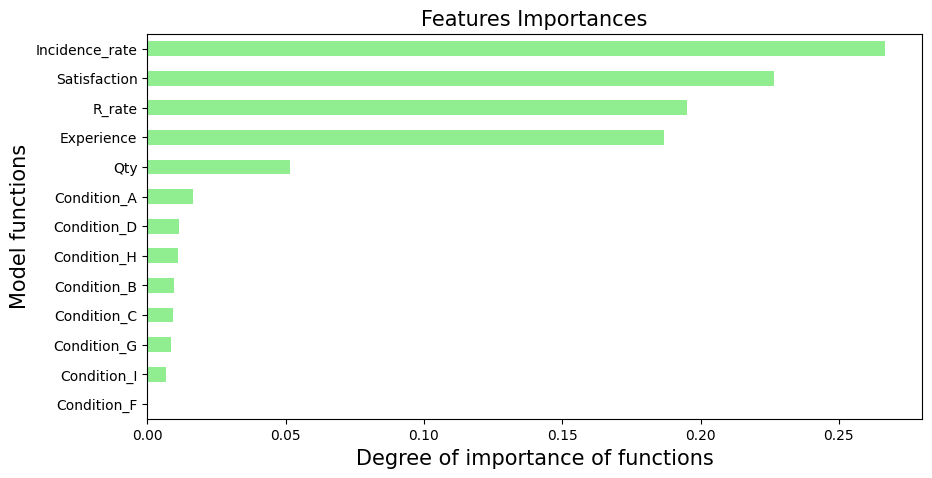

In [35]:
importances = pd.Series(data=forest.feature_importances_,
                        index= X_train.columns)

importances_sorted = importances.sort_values()

plt.figure(figsize = [10,5])
importances_sorted.plot(kind='barh', color='lightgreen')
plt.xlabel("Degree of importance of functions", fontsize = 15)
plt.ylabel("Model functions", fontsize = 15);
plt.title('Features Importances', fontsize = 15)
plt.show()

#### By building our first model and adjusting its parameters, we managed to achieve 94% accuracy on the test data and very low error.
The graph above shows which functions are most important for building a model.

### Let's move on to building our second model...
which will try to predict what internal rank a doctor will receive in our company.
First, let's combine all the data that we have into one dataframe.

In [36]:

df1 = pd.merge(doctors,orders, how ='left',on ='DoctorID')
df2 = pd.merge(df1,complaints, how ='left',on ='DoctorID')
df = pd.merge(df2,instructions, how ='inner',on ='DoctorID')

In [37]:
df['Condition_C'] = df['Condition_C'].fillna(df['Condition_C'].mode()[0])
df['Condition_F'] = df['Condition_F'].fillna(df['Condition_F'].mode()[0])
df['Condition_G'] = df['Condition_G'].fillna(df['Condition_G'].mode()[0])
df['Condition_J'] = df['Condition_J'].fillna(df['Condition_J'].mode()[0])

df['Condition_A'] = df['Condition_A'].fillna(df['Condition_A'].mode()[0])
df['Condition_B'] = df['Condition_B'].fillna(df['Condition_B'].mode()[0])
df['Condition_H'] = df['Condition_H'].fillna(df['Condition_H'].mode()[0])
df['Condition_I'] = df['Condition_I'].fillna(df['Condition_I'].mode()[0])
df['Condition_D'] = df['Condition_D'].fillna(df['Condition_D'].mode()[0])
df.fillna(0, inplace = True)


In [38]:
one_hot = pd.get_dummies(df['Instructions']).rename(columns={'Yes':'Instructions_yes'})
df = df.join(one_hot)

df = df.drop(columns= ['Instructions','No'],axis = 1)
df.head()

,DoctorID,Region,Category,Rank,Incidence_rate,R_rate,Satisfaction,Experience,Purchases,OrderID,...,Condition_C,Condition_D,Condition_F,Condition_G,Condition_H,Condition_I,Condition_J,Complaint_Type,Qty,Instructions_yes
0,AHDCBA,4 15,Specialist,Ambassador,49.0,0.90,53.85,1.20,49.0,0,...,False,False,False,False,False,False,Before,0,0.0,1
1,FDHGC,1 14,Specialist,Titanium,12.0,0.85,0.00,0.62,13.0,DGJBGBE,...,False,False,False,False,True,False,Before,Correct,4.0,0
2,FDHGC,1 14,Specialist,Titanium,12.0,0.85,0.00,0.62,13.0,DGJBGBE,...,False,False,False,False,True,False,Before,Incorrect,4.0,0
3,FDHGC,1 14,Specialist,Titanium,12.0,0.85,0.00,0.62,13.0,DGJBGBE,...,False,False,False,False,True,False,Before,Unknown,1.0,0
4,FDHGC,1 14,Specialist,Titanium,12.0,0.85,0.00,0.62,13.0,DGADCHE,...,True,True,False,False,True,True,Before,Correct,4.0,0


In [39]:
y1 = df.loc[:,"Rank"]
X1 =df.loc[:,['Incidence_rate', 'R_rate','Satisfaction', 'Experience','Condition_A','Condition_B', 'Condition_C', 'Condition_D','Condition_F','Condition_G', 'Condition_H', 'Condition_I','Qty','Instructions_yes']]

In [40]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.35,
random_state=11)
X_test1, X_val1, y_test1, y_val1 = train_test_split(X_test1,y_test1 , test_size=0.4,
random_state=11)

tree = DecisionTreeClassifier(max_depth= 11, min_samples_leaf= 1, min_samples_split= 2)
lr = LogisticRegression(C=17.171,)
svc = SVC(kernel = 'linear' , C = 1,gamma = 1e-05,  )

svc.fit(X_train1, y_train1)
tree.fit(X_train1, y_train1)
lr.fit(X_train1,y_train1)

svc_pred = svc.predict(X_test1)
tree_pred = tree.predict(X_test1)
lr_pred = lr.predict(X_test1)
print("Accuracy of the tree model = %f" %accuracy_score(y_test1, tree_pred) )
print("Accuracy of logistic regression classifier: ", accuracy_score(y_test1, lr_pred))
print("Accuracy of the svc model = %f" %accuracy_score(y_test1, svc_pred) )


Accuracy of the tree model = 0.828571
Accuracy of logistic regression classifier:  0.7428571428571429
Accuracy of the svc model = 0.742857


In [41]:
print("f1-score of the svc model on test data = %f" %f1_score(y_test1, svc_pred, average='weighted') )
print("f1-score of the tree model on test data = %f" %f1_score(y_test1, tree_pred, average='weighted'))
print("f1-score of the logistic regression on test data = %f" %f1_score(y_test1, lr_pred, average='weighted'))

f1-score of the svc model on test data = 0.660024
f1-score of the tree model on test data = 0.800206
f1-score of the logistic regression on test data = 0.660024


In [42]:
print("f1-score of the svc model on validation data = %f" %f1_score(y_val1, svc.predict(X_val1), average='weighted') )
print("f1-score of the tree model on validation data = %f" %f1_score(y_val1, tree.predict(X_val1), average='weighted') )
print("f1-score of the  logistic regression on validation data = %f" %f1_score(y_val1, lr.predict(X_val1), average='weighted') )


f1-score of the svc model on validation data = 0.802083
f1-score of the tree model on validation data = 0.828810
f1-score of the  logistic regression on validation data = 0.820602


In [43]:
print("Accuracy of the tree model based on verification data = {0:.2f}".format(accuracy_score(y_val1, tree.predict(X_val1))))
print("Accuracy of the logistic regression classifier based on verification data = {0:.2f}".format(accuracy_score(y_val1, lr.predict(X_val1))))
print("Accuracy of the svc model based on verification data = {0:.2f}".format(accuracy_score(y_val1, svc.predict(X_val1))))


Accuracy of the tree model based on verification data = 0.79
Accuracy of the logistic regression classifier based on verification data = 0.83
Accuracy of the svc model based on verification data = 0.83


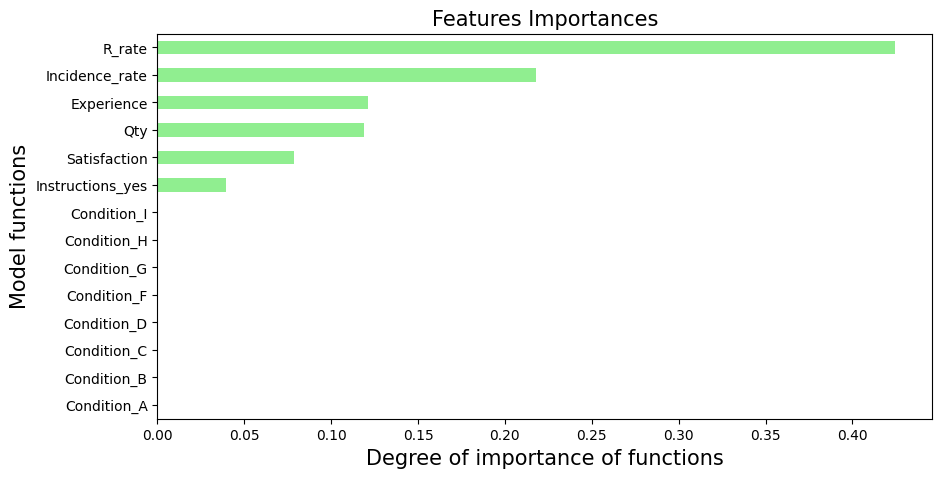

In [44]:
importances1 = pd.Series(data=tree.feature_importances_,
                        index= X_train1.columns)

importances_sorted1 = importances1.sort_values()

plt.figure(figsize = [10,5])
importances_sorted1.plot(kind='barh', color='lightgreen')
plt.xlabel("Degree of importance of functions", fontsize = 15)
plt.ylabel("Model functions", fontsize = 15);
plt.title('Features Importances', fontsize = 15)
plt.show()

## Conclusion...
After training and testing the models, we obtained good accuracy for the multiclass classification problem, both in the first and in the second case. The models are good at predicting which segments our doctors will fall into and what internal rank they will have. All this , of course , still requires checking for new data .

### We can say that we have completed the tasks set in this competition and answered all the questions of interest.


Once again, the beauty of data analysis and machine learning is that if there is feedback from the company and the marketing department, receiving explanations on our data, and not independently interpreting their values, you can quickly influence our models, make changes to them and their goals.

## Thank you for reading to the end!

## 💪 Competition challenge

Create a report that covers the following:
1. How many doctors are there in each region? What is the average number of purchases per region?
2. Can you find a relationship between purchases and complaints?
3. Define new doctor segments that help the company improve marketing efforts and customer service.
4. Identify which features impact the new segmentation strategy the most.
5. Your team will need to explain the new segments to the rest of the company. Describe which characteristics distinguish the newly defined segments.